In [7]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import requests
from matplotlib import pyplot as plt
from matplotlib import style


# Target website, S&P 500
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Add headers so Wikipedia thinks you are a browser
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}

response = requests.get(url, headers=headers)
# raises an error if the request fails
response.raise_for_status()  

# Now parse the tables from the HTML text
tables = pd.read_html(response.text)


# Find which table contains the 'Symbol' and 'GICS Sector' columns
for i, table in enumerate(tables):
    print(f"Table {i} columns: {list(table.columns)}")

# The second table (index 1) is the S&P 500 list
dj = tables[0]
print(dj.head())

# Group tickers by industry and store in a dictionary
industry_dict = (
    dj
    .groupby('GICS Sector')['Symbol']
    .apply(list)
    .to_dict()
)

# Print nicely
for industry, tickers in industry_dict.items():
    print(f"{industry}: {tickers}")

Table 0 columns: ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']
Table 1 columns: [('Effective Date', 'Effective Date'), ('Added', 'Ticker'), ('Added', 'Security'), ('Removed', 'Ticker'), ('Removed', 'Security'), ('Reason', 'Reason')]
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois

C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\1144653965.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [3]:
def analysis(symbols, s_Date = "2025-10-01", e_Date = "2025-11-31"):
    all_data = []
    
    for ticker in symbols:
        # Download monthly data
        data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
        data.columns = data.columns.get_level_values(0)
        
        # Keep only Open and Close
        data = data[['Open', 'Close']]
        data.reset_index(inplace=True)
        
        # Calculate percentage change
        data['% Change'] = ((data['Close'] - data['Open']) / data['Open']) * 100

        # Find 5DA and 20DA
        data['5DA'] = data['Close'].rolling(window=5).mean()
        data['20DA'] = data['Close'].rolling(window=20).mean()
        # Add ticker symbol
        data['Ticker'] = ticker
        data = data[['Date', 'Ticker', 'Open', 'Close', '% Change', '5DA', '20DA']]
        
        all_data.append(data)
    
    # Combine all data
    final = pd.concat(all_data, ignore_index=True)
    
    # Format values
    final['Open'] = final['Open'].apply(lambda x: f"${x:.2f}")
    final['Close'] = final['Close'].apply(lambda x: f"${x:.2f}")
    final['% Change'] = final['% Change'].apply(lambda x: f"{x:.2f}%")
    final['5DA'] = final['5DA'].apply(lambda x: f"{x:.2f}%") 
    final['20DA'] = final['20DA'].apply(lambda x: f"{x:.2f}%")
    # Sort by date and ticker
    final = final.sort_values(by=['Date', 'Ticker'])
    
    # Display clean, centered table for each date
    for date, group in final.groupby('Date'):
        print(f"\n{date.date()}")
        print(tabulate(group[['Ticker', 'Open', 'Close', '% Change']].values,
                       headers=['Ticker', 'Open', 'Close', '% Change'], 
                       tablefmt='pretty', 
                       stralign='center', 
                       numalign='center'))
        print()
    
    return final



C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed


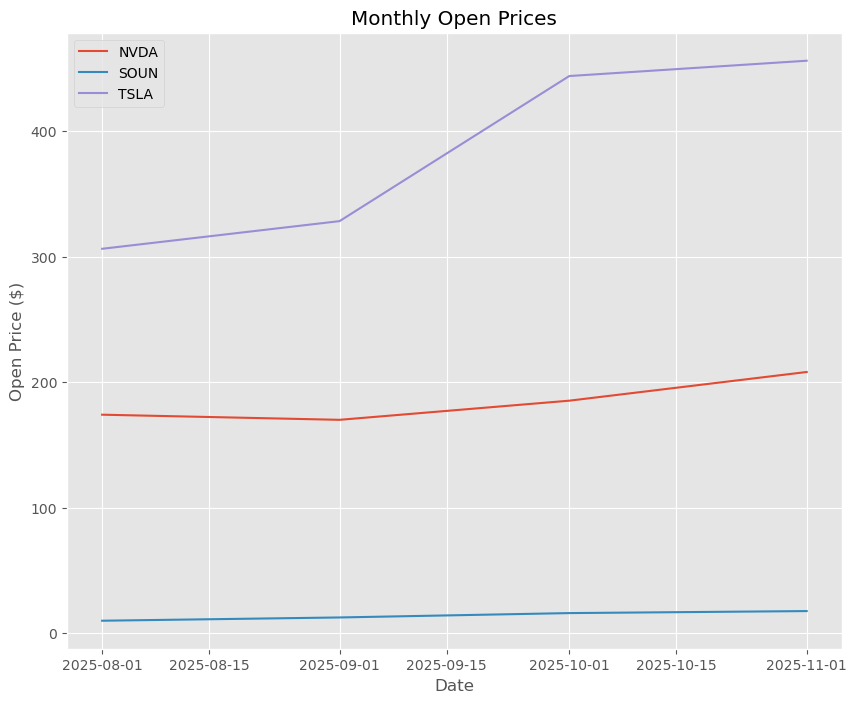

In [14]:
x = analysis(["TSLA", "NVDA", "SOUN"])

# convert numeric values
x["Open"] = x["Open"].replace('[\$,]', '', regex=True).astype(float)

style.use("ggplot")
plt.figure(figsize=(10, 8))

for ticker, group in x.groupby("Ticker"):
    plt.plot(group["Date"], group["Open"], label=ticker)

plt.title("Monthly Open Prices")
plt.xlabel("Date")
plt.ylabel("Open Price ($)")
plt.legend()
plt.show()


In [4]:
industry_results = {}
for industry, tickers in industry_dict.items():
    print(f"\n=== {industry} ===")
    final = analysis(tickers)
    industry_results[industry] = final


=== Communication Services ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argum


=== Consumer Discretionary ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel


=== Consumer Staples ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1mo 2025-08-01 -> 2025-11-28)')
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", int


=== Energy ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel


=== Financials ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel


=== Health Care ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel


=== Industrials ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel


=== Information Technology ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel


=== Materials ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel


=== Real Estate ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel


=== Utilities ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_26112\233323217.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2025-08-01", end="2025-11-28", interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel

In [5]:
print(industry_results)

{'Communication Services': Price       Date Ticker     Open    Close % Change
12    2025-08-01   CHTR  $270.53  $265.58   -1.83%
16    2025-08-01  CMCSA   $33.00   $33.61    1.86%
88    2025-08-01    DIS  $117.59  $118.38    0.67%
20    2025-08-01     EA  $152.59  $171.76   12.56%
28    2025-08-01    FOX   $50.64   $54.28    7.17%
..           ...    ...      ...      ...      ...
71    2025-11-01   TMUS  $209.31  $206.29   -1.44%
83    2025-11-01    TTD   $49.92   $47.24   -5.37%
75    2025-11-01   TTWO  $257.75  $252.43   -2.06%
87    2025-11-01     VZ   $39.51   $39.32   -0.48%
95    2025-11-01    WBD   $22.50   $22.60    0.44%

[96 rows x 5 columns], 'Consumer Discretionary': Price       Date Ticker      Open     Close % Change
0     2025-08-01   ABNB   $130.04   $130.53    0.38%
4     2025-08-01   AMZN   $217.21   $229.00    5.43%
8     2025-08-01   APTV    $67.65    $79.53   17.56%
12    2025-08-01    AZO  $3816.88  $4198.53   10.00%
16    2025-08-01    BBY    $63.70    $72.70   

In [ ]:
print(